In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/survey_results_public.pkl"

In [4]:
ROLE_COLS = ['DevType']
TECH_COLS = ['LanguageHaveWorkedWith',
                  'DatabaseHaveWorkedWith',
                  'WebframeHaveWorkedWith',
                  'MiscTechHaveWorkedWith',
                  'ToolsTechHaveWorkedWith']

In [5]:
# Load packages
import pandas as pd
import numpy as np
import logging
import pickle
import os
import yaml

import plotly
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000

# Read data and preprocess data

In [6]:
# Read Data
df = pd.read_pickle(DATA_PATH)

In [7]:
# One hot encode
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                               columns=binarizer.classes_,
                               index=df[col].index)
    encoded_dfs[col] = encoded_df

# Merge 1-hot encoded
ohe_df = pd.concat(encoded_dfs, axis=1)

In [8]:
# Prepare sub data frames
skills_ohe = ohe_df.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)

In [9]:
tsne_projection = TSNE(n_components=2,
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca',
                       method='barnes_hut',
                       n_jobs=2,
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_ohe.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [10]:
tsne_projection.shape

(97, 2)

In [11]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

# Cluster

In [18]:
cluster_range = list(range(10,25))
silhotte_scores = []
best_cluster_model = None

for n_clusters in cluster_range:
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters , linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)

    silhotte_scores.append(silhouette_score(tsne_projection, cluster_labels))


    if silhotte_scores[-1] == max(silhotte_scores):
        best_cluster_model = cluster_model


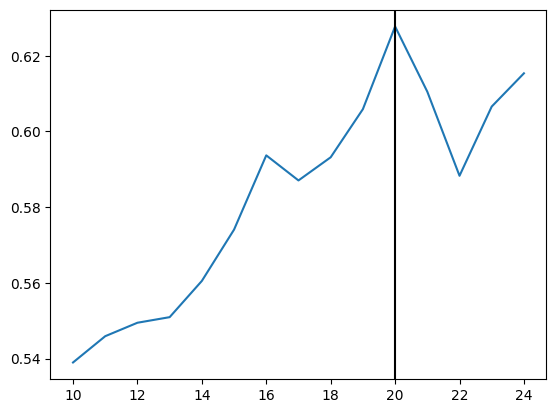

In [19]:
plt.plot(cluster_range, silhotte_scores)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [20]:
cluster_labels = ["skills_group_" + str(label)
                 for label in best_cluster_model.labels_]

In [24]:
fig = px.scatter(x=tsne_projection[0],
                 y=tsne_projection[1],
                 text=tsne_projection.droplevel(0).index,
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [25]:
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)

skills_group_0
['Julia', 'Matlab', 'Python', 'R', 'Django', 'FastAPI', 'Flask', 'Keras', 'NumPy', 'Pandas', 'TensorFlow', 'Torch/PyTorch']
skills_group_1
['Go', 'Rust', 'DynamoDB', 'PostgreSQL', 'Ansible', 'Docker', 'Git', 'Kubernetes', 'Terraform']
skills_group_10
['Unity 3D', 'Unreal Engine']
skills_group_11
['Svelte', 'Deno']
skills_group_12
['Chef', 'Flow', 'Pulumi', 'Puppet']
skills_group_13
['Groovy', 'Java', 'Kotlin', 'Oracle', 'Spring']
skills_group_14
['TypeScript', 'Angular', 'Angular.js', 'Cordova']
skills_group_15
['Ruby', 'Ruby on Rails']
skills_group_16
['Dart', 'Firebase', 'Flutter']
skills_group_17
['Scala', 'Apache Spark', 'Hadoop']
skills_group_18
['Bash/Shell', 'Perl']
skills_group_19
['Objective-C', 'Swift']
skills_group_2
['C#', 'F#', 'PowerShell', 'SQL', 'VBA', 'Microsoft SQL Server', 'ASP.NET', 'ASP.NET Core ', '.NET Core / .NET 5', '.NET Framework', 'Xamarin']
skills_group_3
['Node.js', 'MongoDB', 'Express', 'Gatsby', 'React.js', 'React Native', 'Yarn']
skills_g

# Create new features

In [30]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [42]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,skills_group_18,skills_group_19,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,4,0,0,2,0,1
1,2,3,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,1,0,0
2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0
4,4,4,0,0,0,0,0,0,0,2,1,0,1,1,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,0,2,0,0,0,2,0,0,0,0,0,0,1,0,1,1,0,0,0,0
83435,1,2,2,0,0,0,0,1,2,0,0,0,0,1,4,0,1,1,0,1
83436,6,6,0,0,0,2,0,0,0,1,0,0,0,1,0,0,2,0,0,0
83437,7,5,0,0,0,0,0,0,0,0,1,0,0,4,0,0,3,1,0,0


# Export new features

In [43]:
features_path = "/content/drive/MyDrive/Colab Notebooks/datasets/features_skills_clusters.pkl"
fe_clustered_skills.to_pickle(features_path)